In [ ]:
! gdown --id 1tO13aN1nnJqupL-JkydxBg7H5ET4y0HM

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tO13aN1nnJqupL-JkydxBg7H5ET4y0HM
To: /content/yelp_reviews_gen.csv
100% 4.67G/4.67G [00:32<00:00, 145MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gensim
import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
# Use cuda if present
device = torch.device("cuda")
print("Device available for running: ",device)

Device available for running:  cuda


In [ ]:
DATASET_CSV_PATH = './yelp_reviews_gen.csv'
OUTPUT_FOLDER = './OpData'
top_data_df = pd.read_csv(DATASET_CSV_PATH)

In [ ]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 3:
        return -1
    else:
        return 1

# Mapping stars to sentiment into three categories
top_data_df['sentiment'] = [ map_sentiment(x) for x in top_data_df['stars']]

In [ ]:
# Function to retrieve top few number of each category
def get_top_data(top_n = 5000):
    top_data_df_positive = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    # top_data_df_negative = top_data_df[top_data_df['sentiment'] == -1].head(top_n)
    top_data_df_neutral = top_data_df[top_data_df['sentiment'] == -1].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_neutral])
    return top_data_df_small

# Function call to get the top 10000 from each sentiment
top_data_df_small = get_top_data(top_n=10000)

In [ ]:
#Simple Preprocessing of data

from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer

# Tokenize the text column to get the new column 'tokenized_text'
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 

# Get the stemmed_tokens
porter_stemmer = PorterStemmer()
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]


In [ ]:
# Splitting into Train and Test Sets

from sklearn.model_selection import train_test_split

# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id', 'stemmed_tokens']], 
                                                        top_data_df_small['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train sentiments
 1    7005
-1    6995
Name: sentiment, dtype: int64
Value counts for Test sentiments
-1    3005
 1    2995
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index             business_id  cool                 date  funny  \
0  22876  _cndcbuaqSRW5f-MeZasNw   0.0  2016-05-20 18:52:45    0.0   
1  20123  uFF40n9pOqHK1ciajdoSEw   1.0  2011-07-01 03:44:45    0.0   
2  18063  YisnHfR8rvlYFNtauQF14w   0.0  2016-08-05 12:21:51    0.0   
3    546  4WdDY97x4GdMYtyk1KQMnw   0.0  2013-11-14 01:20:24    1.0   
4   6079  6ZUERrfjvr7HGOB6uwFLZQ   0.0  2013-10-24 11:07:55    0.0   

                review_id  stars  \
0  S1AEveqyNQ7upnoKe6R4Mw    1.0   
1  2K-CXKsz8vFzAEQBQ6e9lw    3.0   
2  c_Iy6yFpJzQqCsYb5IX-rw    3.0   
3  abKghvZEZue9xTHBRpZFAw    4.0   
4  HZP700rUc8OdapSAZMBrdA    2.0   

                                                text  useful  \
0  Came here last week for my wife and  I's 3rd w... 

In [89]:
from gensim.models import Word2Vec
size = 500
window = 3
min_count = 1
workers = 3
sg = 1
NUM_CLASSES = 2

# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + '/models/'+'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file = OUTPUT_FOLDER + '/models/' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, vector_size=size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(top_data_df_small, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

20000


In [90]:
max_sen_len = top_data_df_small.stemmed_tokens.map(len).max()
padding_idx = w2vmodel.wv.key_to_index['pad']
def make_word2vec_vector_lstm(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.key_to_index:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.key_to_index[word]
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [91]:
# Function to get the output tensor
def make_target(label):
    if label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
    else:
        return torch.tensor([1], dtype=torch.long, device=device)

In [92]:
batch_size = 50
class SentimentAnalysisLSTM(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER + '/models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv

        # The embedding layer takes the vocab size and the embeddings size as input
        # self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.key_to_index['pad'])

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        # self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, NUM_CLASSES) 
        


    def forward(self, x, hidden):
        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        # out = self.dropout(out)
        out = self.fc(out)
        out = self.relu(out)
        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, 1, 32), torch.zeros(1, 1, 32))

In [93]:
vocab_len = len(w2vmodel.wv)

lstm_model = SentimentAnalysisLSTM(vocab_size=vocab_len, embedding_dim = 500, hidden_dim = 32, dropout=0.3)
lstm_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
num_epochs = 10

# Open the file for writing loss
loss_file_name = OUTPUT_FOLDER +  '/plots/' + 'lstm3_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
lstm_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    h0, c0 =  lstm_model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)
    for index, row in X_train.iterrows():
        # input = row[0].to(device)
        # target = row[1].to(device)

        # Make the bag of words vector for stemmed tokens 
        input = make_word2vec_vector_lstm(row['stemmed_tokens'])
        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = lstm_model(input, (h0, c0))
            loss = loss_function(out, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
    losses.append(loss.item())


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(lstm_model, OUTPUT_FOLDER +'/'+'lstm3_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(input.cpu().numpy())
print("Output vector")
print(out)
print(torch.argmax(out, dim=1).cpu().numpy()[0])

Epoch1
Epoch ran :1
Epoch2
Epoch ran :2
Epoch3
Epoch ran :3
Epoch4
Epoch ran :4
Epoch5
Epoch ran :5
Epoch6
Epoch ran :6
Epoch7
Epoch ran :7
Epoch8
Epoch ran :8
Epoch9
Epoch ran :9
Epoch10
Epoch ran :10
Input vector
[[  247    43   251   180     0    33     2   170    46   345   746     1
  12685   107   273    60     2  1729   107   270     2   841    36   662
     32  2259  1619   203     1   265     3   178    48     0  1749   128
     32     0   178   968   243    15   261     1   490   467  1231     0
     34    22     0    78     7   210    30  5093  1149  1149  1149  1149
   1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149
   1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149
   1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149
   1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149
   1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149  1149
   1149  1149  1149  1149  1149  1149  1149  

Index(['iter', ' loss'], dtype='object')
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Index(['iter', ' loss'], dtype='object')


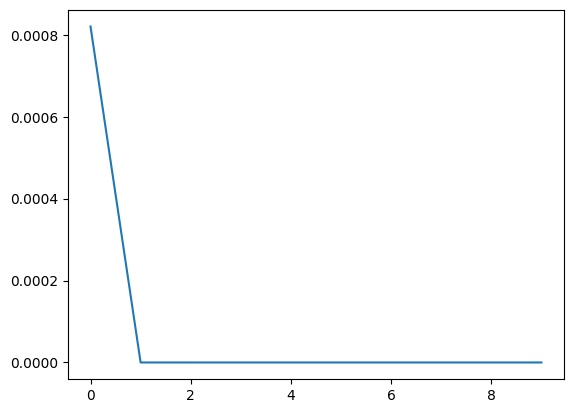

In [94]:
from sklearn.metrics import classification_report
bow_lstm_predictions = []
original_lables_cnn_bow = []
lstm_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER + '/plots/'+'lstm3_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_lstm(row['stemmed_tokens'])
        probs, hidden = lstm_model(bow_vec, (h0, c0))
        _, predicted = torch.max(probs.data, 1)
        bow_lstm_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_cnn_bow,bow_lstm_predictions))
loss_file_name = OUTPUT_FOLDER +  '/plots/' + 'lstm3_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER +'/plots/' + 'loss_plt_500_padding_30_epochs.pdf')
